# **A Tutorial on "A Joint Convolutional and Spatial Quad-Directional LSTM Network for Phase Unwrapping**"

**Malsha Perera** and **Ashwin De Silva**

*Department of Electronics and Telecommunication Engineering, 
University of Moratuwa, Sri Lanka*

# Welcome

This tutorial walks you through the implementation of deep neural architecture introduced in the ICASSP 2021 conference paper titled "[A Joint Convolutional and Spatial Quad-Directional LSTM Network for Phase Unwrapping](https://ieeexplore.ieee.org/document/9414748)". For a detailed description about the methods and experiments carried out, the viewer is referred to the aforementioned paper. A video presentation about this work can be found [here](https://www.youtube.com/watch?v=RS5yPn5KHfU&t=680s).


# Mount Google Drive

In [ ]:
## Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import Libraries

In [ ]:
import numpy as np
import h5py
import os
import matplotlib as mpl
mpl.style.use('default')
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pylab as plt2
from scipy.stats import gennorm, poisson, norm

from keras.layers import Activation, BatchNormalization, Conv2D, UpSampling2D, Conv2DTranspose, concatenate
from keras.layers import MaxPooling2D, Dropout, Input, AveragePooling2D, Reshape, Permute, UpSampling2D
from keras.layers import SimpleRNN, Bidirectional, LSTM
from keras.layers import Lambda
from keras.models import load_model, Model
from keras.losses import sparse_categorical_crossentropy
import tensorflow as tf

from keras.optimizers import *
import keras.backend as K
import keras
from keras.callbacks import ModelCheckpoint, EarlyStopping
K.set_image_data_format('channels_last')

# Utilities

In [ ]:
def simulate(size, m_1, m_2, C, A, mu_x, mu_y, sigma_x, sigma_y):
  """
  creates an arbitrary phase map by mixing gaussian blobs and adding ramps
  """
  x = np.arange(0, size[0], 1)
  y = np.arange(0, size[0], 1)
  xx, yy = np.meshgrid(x, y, sparse=True)
  I = np.zeros(size)
  ## mix randomly shaped and placed gaussian blobs
  for i in range(len(sigma_x)):
      a = (xx-mu_x[i])**2/(2*sigma_x[i]**2) + (yy-mu_y[i])**2/(2*sigma_y[i]**2)
      I += A[i]*np.exp(-a)
  ## add ramp phase with random gradients and shifts
  I = m_1*xx + m_2*yy + C + 0.1*I
  return I

def wrap(phi):
  """
  wraps the true phase signal within [-pi, pi]
  """
  return np.angle(np.exp(1j*phi))

def rescale(im, range):
  """
  mini-max rescales the input image
  """
  im_std = (im - im.min()) / (im.max() - im.min())
  im_scaled = im_std * (range[1] - range[0]) + range[0]
  return im_scaled

def create_random_image(size):
  """
  creates an randomly simulated true phase map
  """ 
  array_len = np.random.randint(2, 5)
  m = np.random.uniform(0, 0.5, [2])
  C = np.random.randint(1, 10)
  A = np.random.randint(50, 1000, array_len)
  mu_x = np.random.randint(20, 235, array_len)
  mu_y = np.random.randint(20, 235, array_len)
  sigma_x = np.random.randint(10, 45, array_len)
  sigma_y = np.random.randint(10, 45, array_len)
  I = simulate(size, m[0], m[1], C, A, mu_x, mu_y, sigma_x, sigma_y)
  return I


def plot(*argv, titles=None):
  """
  plots a given number of phase maps
  """
  if len(argv) == 1:
    f, ax = plt.subplots(1, 1, sharey=True, figsize=(5, 5))
    if titles is not None:
      ax.set_title(titles)
    a = ax.imshow(argv[0].squeeze(), cmap='jet')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    f.colorbar(a, cax=cax)
    plt.show()
  else:
    f, axes = plt.subplots(1, len(argv), sharey=True, figsize=(10, 10))
    for i in range(len(argv)):
        if titles is not None:
          axes[i].set_title(titles[i])
        a = axes[i].imshow(argv[i].squeeze(), cmap='jet')
        divider = make_axes_locatable(axes[i])
        cax = divider.append_axes("right", size="5%", pad=0.05)
        f.colorbar(a, cax=cax)
    plt.show()
    f.colorbar(a, cax=cax)

def plot_hist(*argv, titles):
  """
  plots the historgram of the input phase maps
  """
  for i in range(len(argv)):
      hist = np.histogram(argv[i].ravel(), bins=100)
      plt.plot(hist[1][1:], hist[0])
  plt.xlabel("phase values")
  plt.ylabel("frequency")
  plt.title("Histogram Analysis")
  plt.grid()
  if titles is not None:
    plt.legend(titles)
  plt.show()  

def create_dataset(path, size, no_samples, max_lower_bound, max_upper_bound, noise_levels):
  """
  creates the synthetic true-wrapped phase dataset
  """
  wrapped_phase_maps = np.zeros((1, size[0], size[1]))
  true_phase_maps = np.zeros((1, size[0], size[1])) 

  ## create dataset
  for i in range(no_samples):
      print("Creating {:n}/{:n} pairs".format(i+1, no_samples))

      ## generate the true and wrapped phase maps
      I = create_random_image(size)
      lower_bound = (-2) * np.pi * np.random.randint(1, max_lower_bound+1) 
      upper_bound = 2 * np.pi * np.random.randint(1, max_upper_bound+1) 
      I = rescale(I, [lower_bound, upper_bound])
      I_wrap = wrap(I)

      ## adding noise to the true phase before wrapping it
      snr = noise_levels[np.random.randint(0, len(noise_levels))]
      reqSNR = 10**(snr/10)
      sigPower = 1
      sigPower = 10**(sigPower/10)
      noisePower = sigPower/reqSNR
      I_gaun = np.sqrt(noisePower)*norm.rvs(0, 1, size=(256, 256)) # gaussian noise
      I_n = I + I_gaun # noisy true phase
      I_wrap_n = wrap(I_n) # noisy wrapped phase

      wrapped_phase_maps = np.concatenate((wrapped_phase_maps, I_wrap_n.reshape(1, size[0], size[1])), axis=0)
      true_phase_maps = np.concatenate((true_phase_maps, I.reshape(1, size[0], size[1])), axis=0)

  ## save dataset
  no_wrap_counts = max_lower_bound + max_upper_bound + 1
  dataset_id = "Noisy_Phase_Data_{:n}_{:n}pi_{:n}pi.hdf5".format(no_samples, 2*max_lower_bound, 2*max_upper_bound)
  dataset = h5py.File(os.path.join(path, dataset_id), mode='w')
  dataset.create_dataset('psi', data=wrapped_phase_maps[1:, ...])
  dataset.create_dataset('phi', data=true_phase_maps[1:, ...])
  dataset.close()    

# Creating Simulated True Phase Maps

The true phase maps are simulated by randomly setting the parameters of the following equation. 

$$ \phi(x, y) = m_1 x + m_2 y + C + \sum_{n=1}^{N} A_n \exp \Bigg[ - \bigg( \frac{(x - \mu_x)^2}{2\sigma_x^2} + \frac{(y - \mu_y)^2}{2\sigma_y^2} \bigg) \Bigg] \; ; \; \forall (x, y) \in [-128, 127)^2$$ 

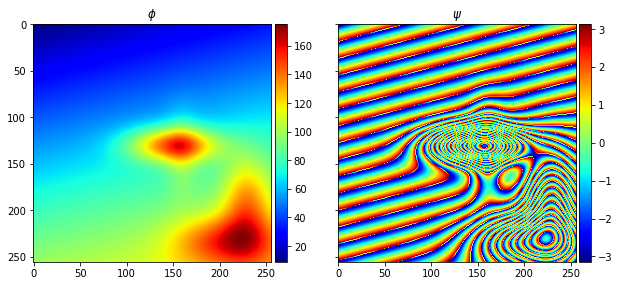

In [ ]:
## example
size = (256, 256)
I = create_random_image(size)
I_wrap = wrap(I)
plot(I, I_wrap, titles=["$\phi$", "$\psi$"])

# Creating Noisy Phase Dataset

The noisy phase dataset is created by randomly adding the specified noise levels (SNRs in dB) to the simulated true phase images before wrapping them.

The following code snippet generates a dataset with $1000$ true-wrapped phase maps of size $256 \times 256$. The maximum and minimum values taken by the true phase map pixels are $2 N_u \pi$ and $2 N_l \pi$ respectively. Noise levels including $0, 5, 10, 20$ and $60 \text{ dB}$ were randomly added to the true phase images before wrapping them. ($N_u = \text{maximum upper bound}$, $N_l = \text{maximum lower bound}$)

In [ ]:
## create the dataset
save_path = '/content/drive/My Drive/DeepUnwrap'
size = (256, 256)
no_samples = 1000
max_lower_bound = 4
max_upper_bound = 4 
noise_levels = [0, 5, 10, 20, 60]

create_dataset(save_path, size, no_samples, max_lower_bound, max_upper_bound, noise_levels)

# Define the Joint Convolutional and SQD LSTM Archiecture

In a nutshell, the architecture is comprised of a fully convolutional encoder-decoder network where the output of the
encoder is passed through the proposed SQD-LSTM module
before fed in to the decoder. The output feature map of the
encoder is able to represent the local information of the input image. Feeding this encoder output to the SQD-LSTM
module allows the network to learn the spatial dependencies
between the local features contained in the encoder output.
Subsequently, the output of SQD-LSTM module is fed in to
the decoder network which increases the resolution of the output through transpose convolutional operations. Furthermore,
in order to combine semantic features from the decoder layers and local features from the encoder layers, we add skip
connections. Adding skip connections
this way, ensures that the network assembles a more refined
output at the later layers.

![](https://drive.google.com/uc?id=1u0FBR0t0jw0zEuCplLuP_g05-Tm6k1r2)

![](https://drive.google.com/uc?id=1qA-Vetv4ztFFhQBukHqHEdSPhH5zSVsA)

In [ ]:
def get_joint_conv_sqd_lstm_net():
    """
    Defines the joint convoltional and spatial quad-directional LSTM network
    """
    ## input to the network
    input = Input((256, 256, 1))

    ## encoder network
    c1 = Conv2D(filters=16, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(input)
    c1 = BatchNormalization()(c1)
    c1 = Activation('relu')(c1)
    p1 = AveragePooling2D()(c1)

    c2 = Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Activation('relu')(c2)
    p2 = AveragePooling2D()(c2)

    c3 = Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Activation('relu')(c3)
    p3 = AveragePooling2D()(c3)

    c4 = Conv2D(filters=128, kernel_size=(3, 3), kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Activation('relu')(c4)
    p4 = AveragePooling2D()(c4)

    # SQD-LSTM Block
    x_hor_1 = Reshape((16 * 16, 128))(p4)
    x_ver_1 = Reshape((16 * 16, 128))(Permute((2, 1, 3))(p4))

    h_hor_1 = Bidirectional(LSTM(units=32, activation='tanh', return_sequences=True, go_backwards=False))(x_hor_1)
    h_ver_1 = Bidirectional(LSTM(units=32, activation='tanh', return_sequences=True, go_backwards=False))(x_ver_1)

    H_hor_1 = Reshape((16, 16, 64))(h_hor_1)
    H_ver_1 = Permute((2, 1, 3))(Reshape((16, 16, 64))(h_ver_1))

    c_hor_1 = Conv2D(filters=64, kernel_size=(3, 3),
                     kernel_initializer='he_normal', padding='same')(H_hor_1)
    c_ver_1 = Conv2D(filters=64, kernel_size=(3, 3),
                     kernel_initializer='he_normal', padding='same')(H_ver_1)

    H = concatenate([c_hor_1, c_ver_1])

    # decoder Network
    u5 = Conv2DTranspose(128, (3, 3), strides=(2, 2), padding='same')(H)
    u5 = concatenate([u5, c4])
    c5 = Conv2D(filters=128, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(u5)
    c5 = BatchNormalization()(c5)
    c5 = Activation('relu')(c5)

    u6 = Conv2DTranspose(64, (3, 3), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c3])
    c6 = Conv2D(filters=64, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Activation('relu')(c6)

    u7 = Conv2DTranspose(32, (3, 3), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c2])
    c7 = Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Activation('relu')(c7)

    u8 = Conv2DTranspose(16, (3, 3), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c1])
    c8 = Conv2D(filters=32, kernel_size=(3,3), kernel_initializer='he_normal', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Activation('relu')(c8)

    ## output layer
    output = Conv2D(filters=1, kernel_size=(1, 1), padding='same', name='out1')(c8)
    output = Activation('linear')(output)

    model = Model(inputs=[input], outputs=[output])
    return model

# Define the Composite Loss Function

Since we formulate the phase unwrapping problem as a regression task, the go to choice for the loss function is Mean Squared Error (MSE) loss. However, our experiments revealed that MSE loss, when employed to the proposed network, shows an insufficient convergence that results in poor phase unwrapping performance. From $\psi = \angle e^{j\phi}$, it follows that $\phi + 2\pi n$ where $\forall n \in \mathbb{Z}$ gives rise to the same wrapped phase $\psi$. Therefore, the phase unwrapping problem of $\psi$ does not have a unique solution. Since MSE loss enforces the network to learn a unique solution, it does not fit well in to the nature of phase unwrapping problem. Hence, a loss function which allows for other solutions at convergence while increasing the similarity between the predicted phase $\hat{\phi}$ and true phase $\phi$ is required. To address these concerns, we adopt the composite loss function $\mathcal{L}_c$ defined below.

$$\mathcal{L}_c = \lambda_1 \mathcal{L}_{var} + \lambda_2 \mathcal{L}_{tv} $$
where,
$$
    \mathcal{L}_{var} = \mathbb{E}\big[(\hat{\phi} - \phi)^2\big] - \big(\mathbb{E} \big[(\hat{\phi} - \phi) \big] \big)^2
$$
$$
    \mathcal{L}_{tv} = \mathbb{E}\big[|\hat{\phi}_x - \phi_x| + |\hat{\phi}_y - \phi_y|\big]
$$
and $\lambda_1$, $\lambda_2$ are the weights assigned for the two losses and were empirically set to 1 and 0.1 respectively during training. The variance of error loss $\mathcal{L}_{var}$ allows for alternate solutions at convergence while the total variation of error loss $\mathcal{L}_{tv}$ increases the similarity between $\hat{\phi}$ and $\phi$ by enforcing the network to match the gradients of them.

In [ ]:
def tv_loss_plus_var_loss(y_true, y_pred):
  """
  Define the composite loss function that includes total variation of errors 
  loss and variance of errors loss
  """
  # total variation loss
  y_x = y_true[:, 1:256, :, :] - y_true[:, 0:255, :, :]
  y_y = y_true[:, :, 1:256, :] - y_true[:, :, 0:255, :]
  y_bar_x = y_pred[:, 1:256, :, :] - y_pred[:, 0:255, :, :]
  y_bar_y = y_pred[:, :, 1:256, :] - y_pred[:, :, 0:255, :]
  L_tv = K.mean(K.abs(y_x - y_bar_x)) + K.mean(K.abs(y_y - y_bar_y))

  # variance of the error loss
  E = y_pred - y_true
  L_var = K.mean(K.mean(K.square(E), axis=(1, 2, 3)) - K.square(K.mean(E, axis=(1, 2, 3))))

  loss = L_var + 0.1 * L_tv
  return loss

# Load the Dataset 

In [ ]:
## load the dataset 
dataset_id = 'Noisy_Phase_Data_1000_8pi_8pi'
save_path = '/content/drive/MyDrive/DeepUnwrap/{}.hdf5'.format(dataset_id)
dataset = h5py.File(save_path, mode='r')
X = np.array(dataset['psi'])
y = np.array(dataset['phi'])

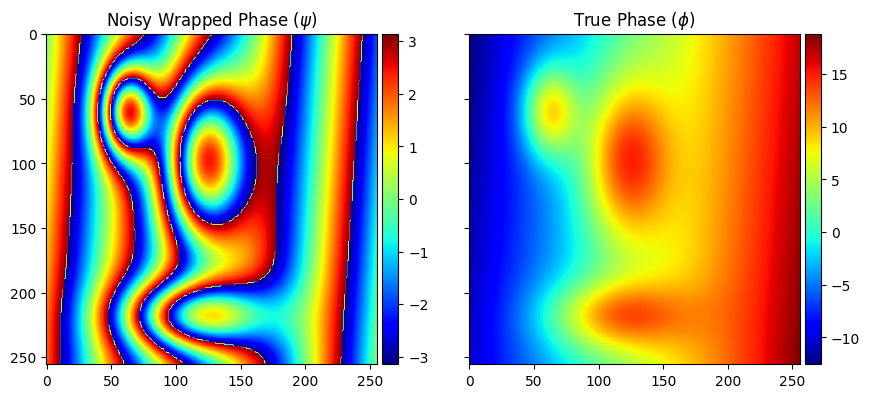

In [ ]:
## visualize a pair
idx = np.random.randint(0, X.shape[0])
plot(X[idx], y[idx], titles=["Noisy Wrapped Phase ($\psi$)", "True Phase ($\phi$)"])

# Compile the Model


In [ ]:
model = get_joint_conv_sqd_lstm_net()
model.summary()

model_id = 'Model_{}'.format(dataset_id)
model_path = '/content/drive/My Drive/DeepUnwrap/{}.h5'.format(model_id)

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=tv_loss_plus_var_loss
)

earlystopper = EarlyStopping(
    monitor='loss',
    patience=10,
    verbose=1
)

model_checkpoint = ModelCheckpoint(
    model_path,
    monitor='loss',
    verbose=1,
    save_best_only=True
)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

# Train the Model

In [ ]:
## train the model
history = model.fit(
    x = X.reshape(X.shape[0], 256, 256, 1),
    y = y.reshape(y.shape[0], 256, 256, 1),
    batch_size=4,
    epochs=100,
    verbose=1,
    callbacks=[model_checkpoint, earlystopper]   
)

Epoch 1/100
250/250 [==============================] - 20s 59ms/step - loss: 11.7992

Epoch 00001: loss improved from inf to 11.79919, saving model to /content/drive/My Drive/DeepUnwrap/Model_Noisy_Phase_Data_1000_8pi_8pi.h5
Epoch 2/100
250/250 [==============================] - 15s 59ms/step - loss: 3.8833

Epoch 00002: loss improved from 11.79919 to 3.88331, saving model to /content/drive/My Drive/DeepUnwrap/Model_Noisy_Phase_Data_1000_8pi_8pi.h5
Epoch 3/100
250/250 [==============================] - 15s 60ms/step - loss: 2.9440

Epoch 00003: loss improved from 3.88331 to 2.94398, saving model to /content/drive/My Drive/DeepUnwrap/Model_Noisy_Phase_Data_1000_8pi_8pi.h5
Epoch 4/100
250/250 [==============================] - 15s 60ms/step - loss: 2.5376

Epoch 00004: loss improved from 2.94398 to 2.53762, saving model to /content/drive/My Drive/DeepUnwrap/Model_Noisy_Phase_Data_1000_8pi_8pi.h5
Epoch 5/100
250/250 [==============================] - 15s 60ms/step - loss: 2.2652

Epoch 00

# Model Convergence

<function matplotlib.pyplot.show>

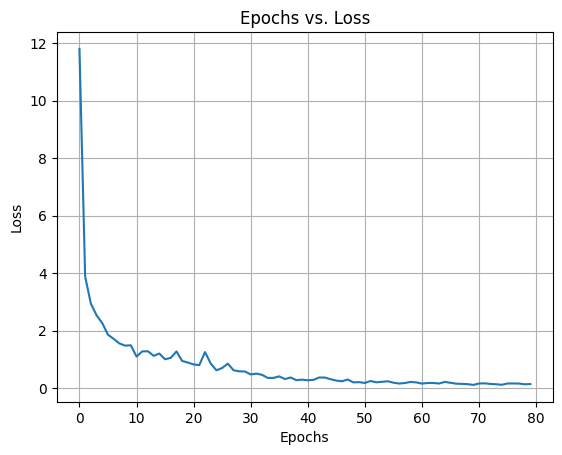

In [ ]:
loss = history.history['loss']
epochs = np.arange(0, len(loss), 1)
plt.plot(epochs, loss)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Epochs vs. Loss")
plt.grid()
plt.show

# (Create) and Load the Test Data

In [ ]:
## create a test dataset (run only once unless there's no need to create a new test set)
save_path = '/content/drive/My Drive/DeepUnwrap'
size = (256, 256)
no_samples = 400
max_lower_bound = 4
max_upper_bound = 4 
noise_levels = [0, 5, 10, 20, 60]

create_dataset(save_path, size, no_samples, max_lower_bound, max_upper_bound, noise_levels)

In [ ]:
## load the test dataset 
dataset_id = 'Noisy_Phase_Data_400_8pi_8pi'
save_path = '/content/drive/MyDrive/DeepUnwrap/{}.hdf5'.format(dataset_id)
dataset = h5py.File(save_path, mode='r')
X_test = np.array(dataset['psi'])
y_test = np.array(dataset['phi'])

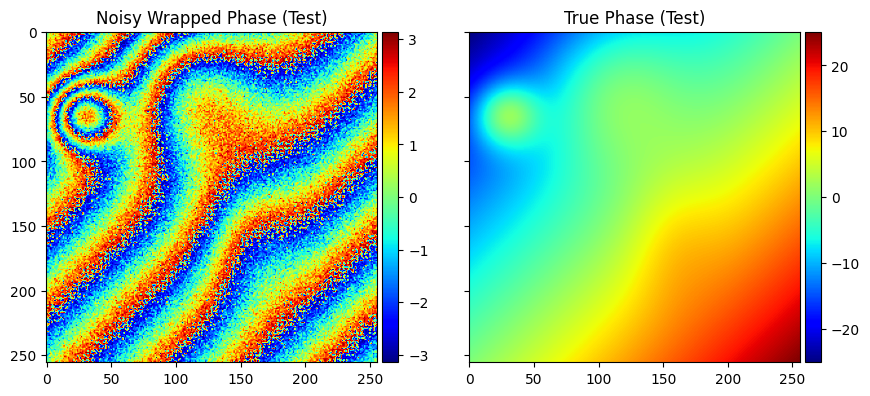

In [ ]:
## visualize a pair
idx = np.random.randint(0, X_test.shape[0])
plot(X[idx], y[idx], titles=["Noisy Wrapped Phase (Test)", "True Phase (Test)"])

# Predict True Phase from Wrapped Phase

In [ ]:
## load trained model
model = get_joint_conv_sqd_lstm_net()

model.compile(
    optimizer=Adam(learning_rate=1e-3),
    metrics=[]
)

model_path = '/content/drive/MyDrive/DeepUnwrap/Model_Noisy_Phase_Data_1000_8pi_8pi.h5'
model.load_weights(model_path)

In [ ]:
## predict true phase
y_pred = model.predict(X_test, batch_size=4)

Due to the nature of the porblem of phase unwrapping, for each wrapped phase $\psi$, there exists a family of solutions (true phases) charactersized by $\phi + 2n\pi, \; n \in \mathbb{Z}$. To avoid this ambiguity when computing the accuracy metrics, we rescale the predicted true phase values ($\hat{\phi}$) to match scale of the true phase values ($\phi$).

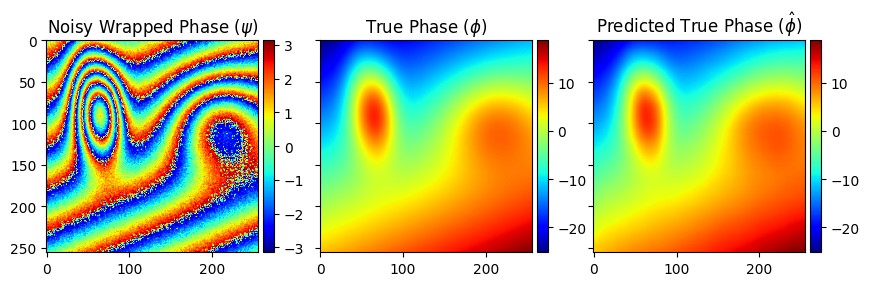

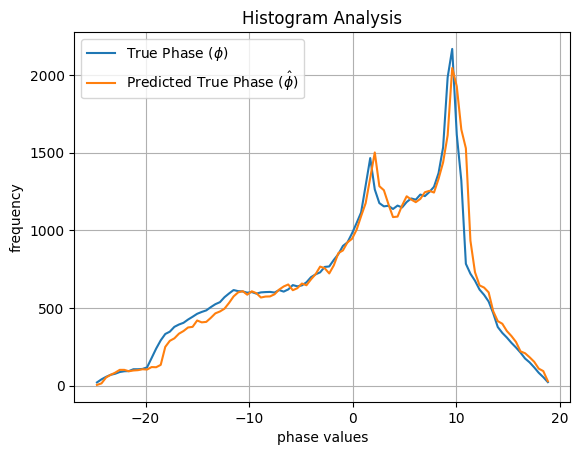

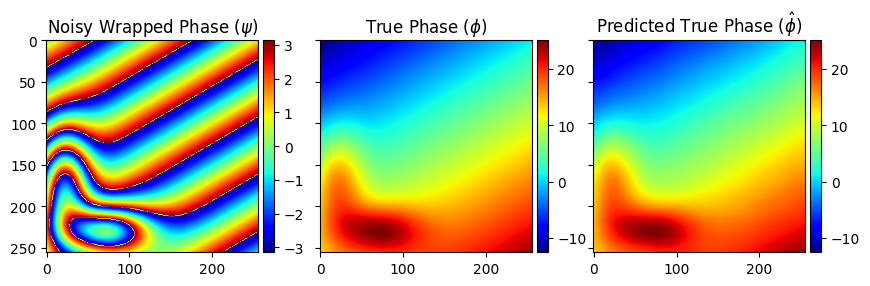

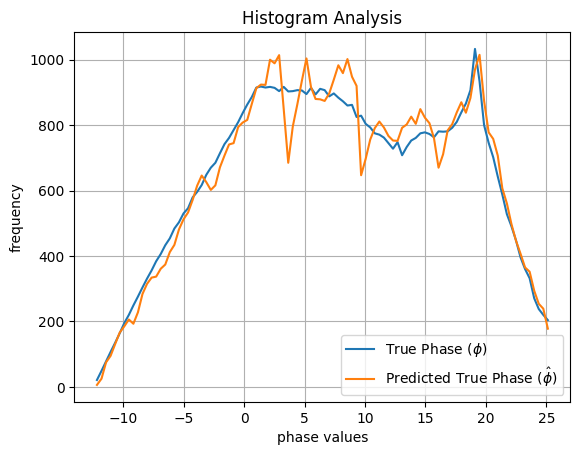

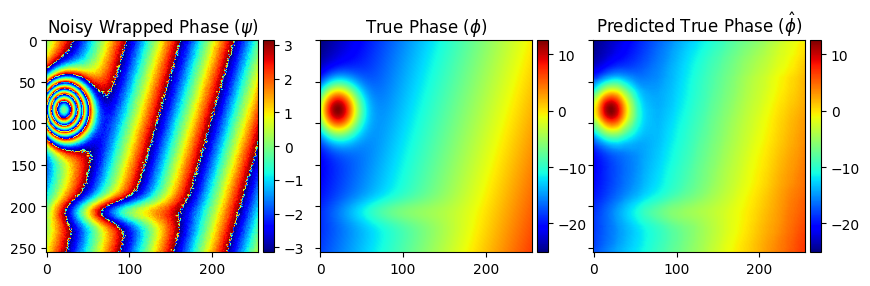

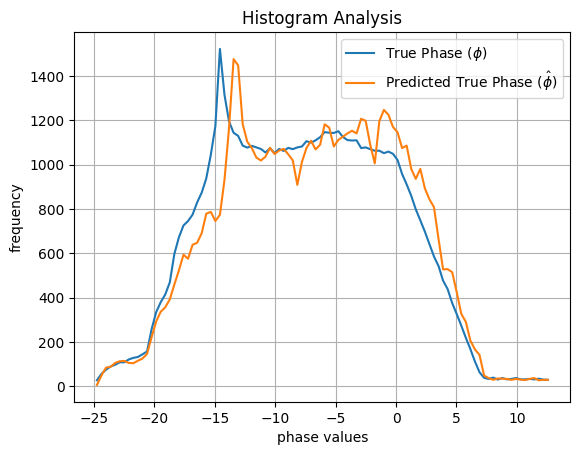

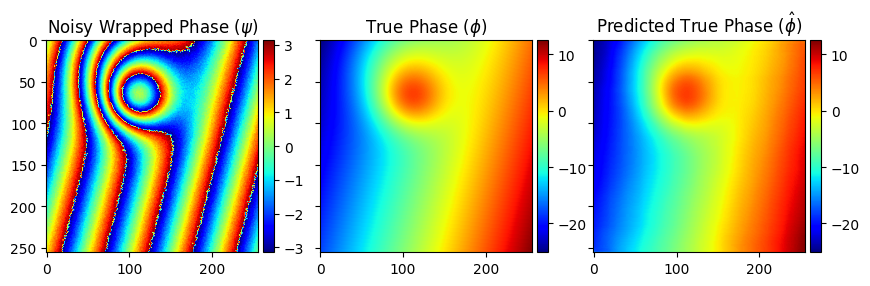

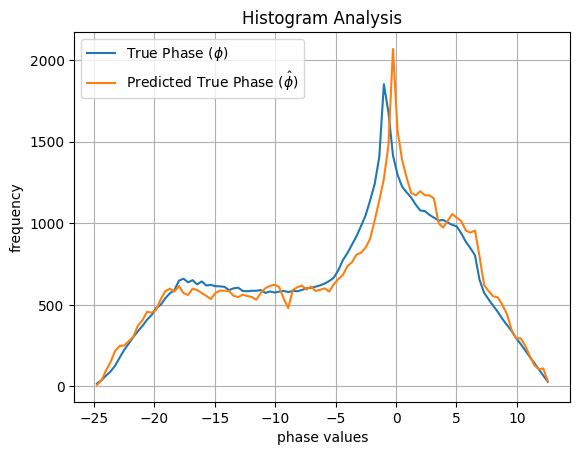

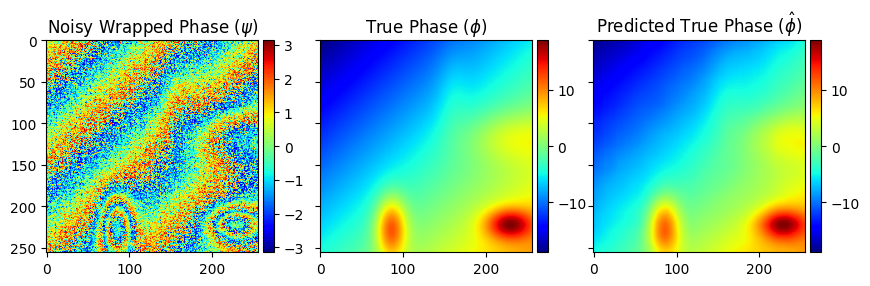

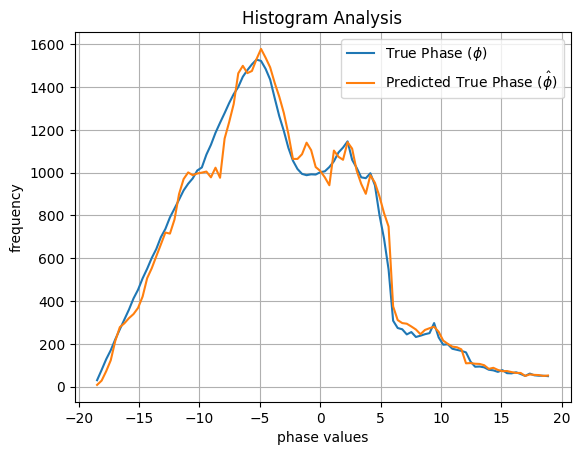

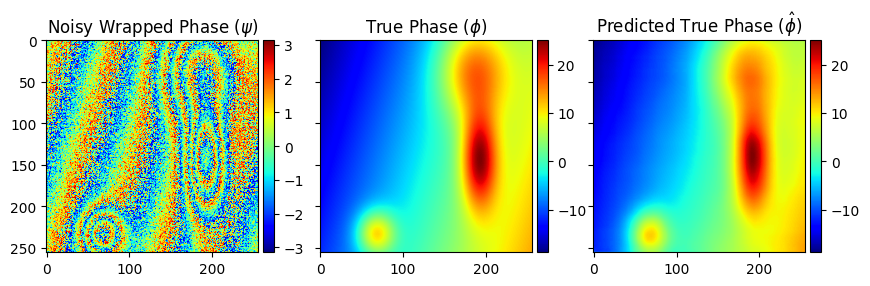

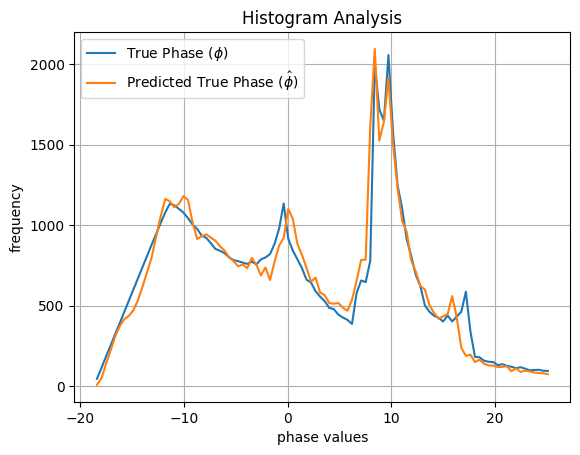

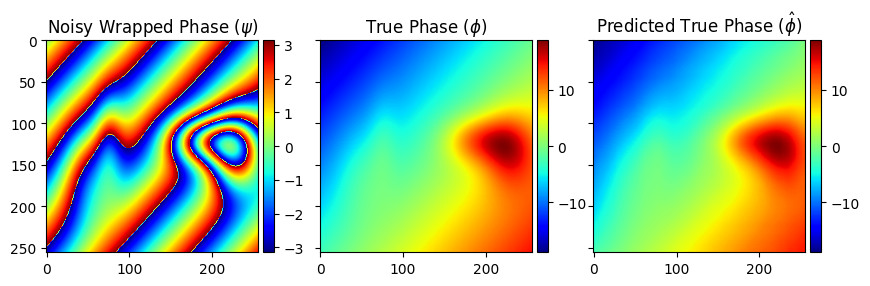

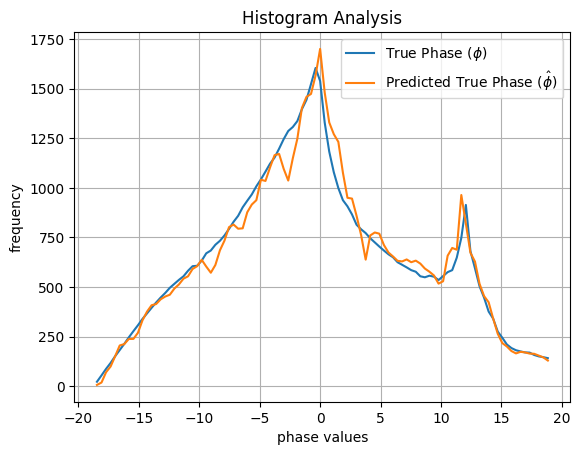

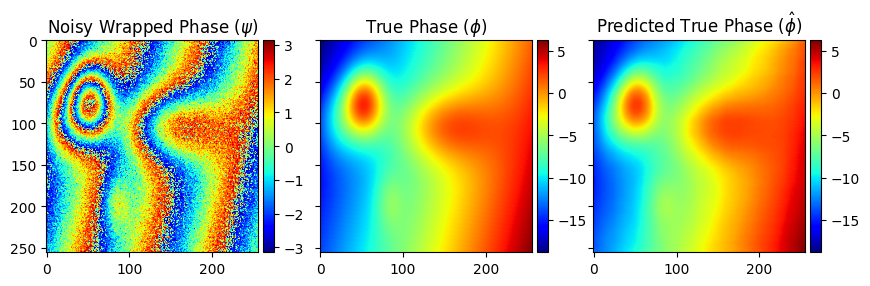

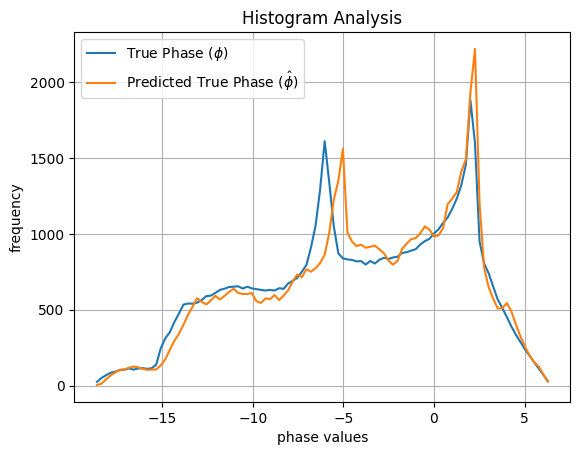

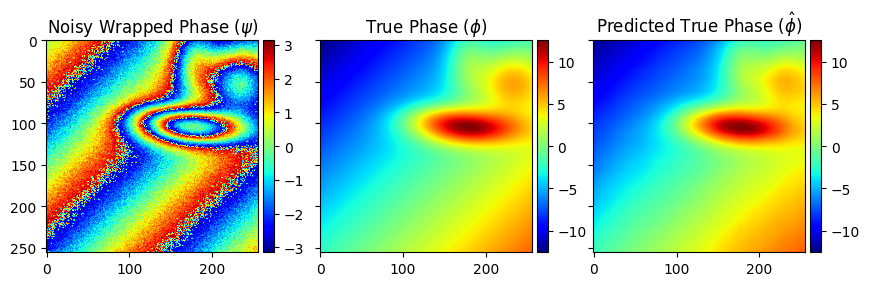

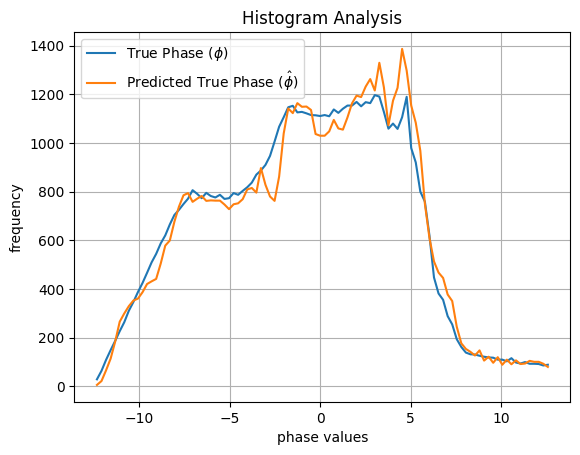

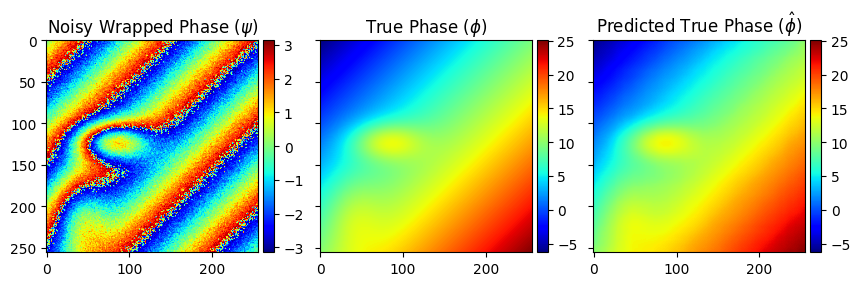

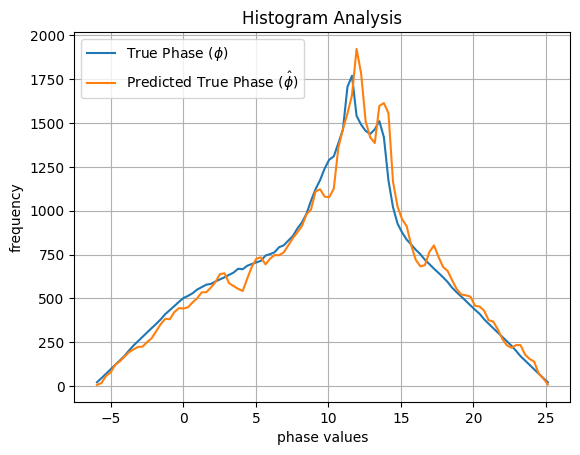

In [ ]:
## visualize
y_pred_scaled = np.empty((0, 256, 256))
for i in range(10):
  Xi = X_test[i]
  yi = y_test[i]
  ypi = y_pred[i]
  
  # match scales of predicted true phase
  min1, max1 = np.min(yi), np.max(yi)
  min2, max2 = np.min(ypi), np.max(ypi)
  temp = (ypi - min2) / (max2 - min2)
  ypi_scaled = temp * (max1 - min1) + min1
  y_pred_scaled = np.vstack((y_pred_scaled, ypi_scaled.reshape(1, 256, 256)))

  # visualize
  plot(Xi, yi, ypi_scaled, titles=["Noisy Wrapped Phase ($\psi$)", "True Phase ($\phi$)", "Predicted True Phase ($\hat{\phi}$)"])
  plot_hist(yi, ypi_scaled, titles=["True Phase ($\phi$)", "Predicted True Phase ($\hat{\phi}$)"])

# Get Accuracy Metrics

We use Normalized Root Mean Squared Error (NRMSE) to report the performance of our method.

$$ \text{NRMSE} = \frac{\sqrt{\mathbb{E}\big[(\phi - \hat{\phi})^2\big]}}{\phi_{max} - \phi_{min}} $$

In [ ]:
## get the scaled predicted true phase values
y_pred_scaled = np.empty((0, 256, 256))
for i in range(X_test.shape[0]):
  Xi = X_test[i]
  yi = y_test[i]
  ypi = y_pred[i]
  
  # match scales of predicted true phase
  min1, max1 = np.min(yi), np.max(yi)
  min2, max2 = np.min(ypi), np.max(ypi)
  temp = (ypi - min2) / (max2 - min2)
  ypi_scaled = temp * (max1 - min1) + min1
  y_pred_scaled = np.vstack((y_pred_scaled, ypi_scaled.reshape(1, 256, 256)))

In [ ]:
## compute NRMSE
error = y_test - y_pred_scaled
r = np.max(y_test, axis=(1, 2), keepdims=True) - np.min(y_test, axis=(1, 2), keepdims=True)
NRMSE = np.mean(np.sqrt(np.mean(error**2, axis=(1, 2)))/r)*100
performance = "NRMSE = {:.2f} %".format(NRMSE)
print(performance)

NRMSE = 1.86 %


# Citation
If you use this work, please cite the following ICASSP 2021 conference paper.

```@INPROCEEDINGS{9414748,  author={Perera, Malsha V. and De Silva, Ashwin},  booktitle={ICASSP 2021 - 2021 IEEE International Conference on Acoustics, Speech and Signal Processing (ICASSP)},   title={A Joint Convolutional and Spatial Quad-Directional LSTM Network for Phase Unwrapping},   year={2021},  volume={},  number={},  pages={4055-4059},  doi={10.1109/ICASSP39728.2021.9414748}}```

$$ \ast \; \ast \; \ast$$